# Beat the Books
#### A data science project by Jonathan Sears
https://jonathansears1.github.io/ 

### Project Plan
The main goal of this project is to find a way to profit of of sports betting. There are several reasons I want to do this. First I want to make money, I feel like that is pretty self explanatory. Additionally, sports books and casinos always stack the odds in their favor, so I think it would be cool to find a way to beat them at their own game. 

### The Plan
My approach to beat the books will be as follows:

1) Build a couple different machine learning models. One that given some data we can aquire before a game starts, predicts the winner of a game (moneyline), one that predicts the point differential (spread), and one that predicts the total number of points (over under). 
2) Scrape the odds from many different sportsbooks. Since sportsbooks operate independently, their odds are constantly changing. Exploting these discrepencies to get the best odds for any bet is essential if you want to beat the books. 
3) Using some math I'm going to calculate my predicted expected value for a given bet, if the expected value > 0, then I will classify it as a winning bet. Theoretically, if I place enough bets and my model is accurate, I should be able to beat the books. 

# Math

### Expected Value and the Law of Large Numbers
There is some important math we will need to have a strong understanding of during this project. The plus EV strategy relies on identifying bets with positive expected values, so it's important to have a strong understanding of what expected values are. The expected value of a bet will be:

    EV = P(event A happens)* (Payoff of event A) + P(event B) * (Payoff of event B)

When looking at this we can see how important it is to properly asses the probability of a given event happening is, as that's what will be the real difference between making and losing money.

The second important tool is the law of large numbers, which states that the more bets we place, the higher probability we have of reaching our expected value. This is important because while we might have a positive EV on a bet this doesn't guarantee that it will hit. What the law of large numbers is saying that if we place 1000 bets with 50% probability of hitting, then we have an incredibly high probability of hitting around 500 of them. Basically, the more bets we place, the closer we should get to converging to our expected value.  

### The Kelly Criterion
The Kelly Criterion is a simple mathematical formula we can use to size our bets:

f<sup>*</sup> = p - (1-p)/b 


**f<sup>*</sup>** is the fraction of our bankroll we should put on the bet

**p** is our estimated probability of winning

**b** is the proportion of the bet we stand to win (eg for 2:1 odds b =2)

# Data
The two datasets I found that I think will come in handy for this project are the 538 ELO model dataset and the spreadspoke historical odds dataset. Unfortunately I can't use the 538 ELO model as a predictor when building my own model, as it was discontinued before the 2023 NFL season. However, I think it could still be useful to compare it to my own model to get a gaugue of how well I'm doing. The spreadspoke dataset will likely be one of the most important finds for this whole project as historical odds, spreads, and over under lines will come in extremely handy when building my own model. Finding free data about the NFL turned out to be a lot harder than I thought. I couldn't find any datasets that had historical box scores or anything like that, so instead I decided to make my own by using webscraping. Lastly I needed to find a way to get current odds of NFL games from a wide range of sportsbooks. The Odds API came in extremely handy for this

**Data Sources:**
 
538 NFL ELO: https://github.com/fivethirtyeight/data/tree/master/nfl-elo

Spreadspoke: https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data

Box scores scraped from: https://www.footballdb.com/games/

Odds API: https://the-odds-api.com/ 



**Sources I didn't end up using for this project but I may use in the future:**

@misc{gilani_sdvpy_2021,
  author = {Gilani, Saiem},
  title = {sportsdataverse-py: The SportsDataverse's Python Package for Sports Data.},
  url = {https://py.sportsdataverse.org},
  season = {2021}
}

NFL Data: https://pypi.org/project/nfl-data-py/

# ETL

In [3]:
#Import tools for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# web scraping tools
import requests
import io
from bs4 import BeautifulSoup
import re 
import json
from random import randint
import sportsdataverse.nfl as sdv_nfl
# preprocessing tools
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
# import potential models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
# import tools to optimize our models
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SequentialFeatureSelector
from multiprocessing import Pool
pd.set_option('display.max_columns',None)

In [93]:
#First lets read in our data
games = pd.read_csv('./Data/spreadspoke_scores.csv')
teams = pd.read_csv('./Data/nfl_teams.csv')
stadiums = pd.read_csv('./Data/nfl_stadiums.csv', encoding="unicode_escape")
nfl_elo = pd.read_csv('./Data/nfl_elo.csv')
recent_elo = pd.read_csv('./Data/nfl_elo_latest.csv')
odds_data = pd.read_excel('./Data/Data.xlsx')
sdv_pl = sdv_nfl.load_nfl_pfr_def()

In [94]:
#Let's also check our data types to make sure everything looks okay
games.dtypes
nfl_elo.dtypes
teams.dtypes
stadiums.dtypes

#convert the date columns to datetime object
nfl_elo.loc[:,'date'] = pd.to_datetime(nfl_elo['date']).dt.floor('D')
recent_elo.loc[:,'date'] = pd.to_datetime(recent_elo['date']).dt.floor('D')
games.loc[:,'schedule_date'] = pd.to_datetime(games['schedule_date']).dt.floor('D')


In [95]:
# There's a lot of data in the elo datasets and a lot of it won't be useful for us. Lets drop all the data from before the superbowl era
sb_era_elo = nfl_elo[nfl_elo['season'] >= 1965]
#and lets add te recent games to this dataset as well
sb_era_elo = pd.concat([recent_elo,sb_era_elo])
#reindex the df
sb_era_elo = sb_era_elo.reindex(index=range(len(sb_era_elo)),copy=False)
#drop a random column that has all NaNs
sb_era_elo.dropna(subset = ['team1','team2','date','elo1_pre','elo2_pre'],inplace=True)

In [96]:
#Lets also drop games without betting data from the scores dataset
games.dropna(subset='spread_favorite', inplace=True)
games.dropna(subset='over_under_line', inplace=True)


In [97]:
games['schedule_date'] = pd.to_datetime(games['schedule_date'])


In [98]:
sb_era_elo['date'] = pd.to_datetime(sb_era_elo['date'])

Let's make some new columns indicating the winner of the game, who covered the spread, and if the over hit. 
For the over we will use 0 if the over did not hit, 1 if the over did hit, and 2 if the game was a push

In [99]:
def winner(df):
    if df['score_home'] > df['score_away']:
        return df['team_home']
    elif df['score_away'] > df['score_home']:
        return df['team_away']
    else:
        return 'Tie'
    
def over(df):
    if float(df['score_home'] + df['score_away']) > float(df['over_under_line']):
        return "Over"
    elif float(df['score_home'] + df['score_away']) < float(df['over_under_line']):
        return "Under"
    else:
        return "Push"
#Define functions to get the abbreviation for each team in the games dataset
def find_home_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_home']]
    abrev = match.iloc[0]['team_id']
    return abrev
def find_away_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_away']]
    abrev = match.iloc[0]['team_id']
    return abrev
games['home_abrev'] = games.apply(find_home_team_abbrev,axis = 1)
games['away_abrev'] = games.apply(find_away_team_abbrev,axis = 1)
def find_point_diff(df):
    '''
    function to find the actual point differential in a game. 
    define the point differential as favored team points - other team points
    This function is supposed to be applied to a dataframe
    '''
    if df['team_favorite_id'] == df['home_abrev']:
        return df['score_home'] - df['score_away']
    elif df['team_favorite_id'] == df['away_abrev']:
        return df['score_away'] - df['score_home']
    elif df['team_favorite_id'] == "PICK":
        return df['score_home'] - df['score_away']
    else:
        return np.nan
 
games['point_diff'] = games.apply(find_point_diff,axis=1)
games['point_total'] = games['score_home'] + games['score_away']
games['winner'] = games.apply(winner, axis = 1)
games['over'] = games.apply(over, axis = 1)

### Merging Datasets!

Let's merge the games and elo datasets into one massive dataset we can use to build our model

In [100]:
#Create a gameID from the two date a dame was played, and the two team name abbreviations in alphabetical order
#function made for the teams_df
def make_game_id(teams_df):
    team1 = teams_df['home_abrev']
    team2 = teams_df['away_abrev']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(teams_df['schedule_date'])
    gameID = date_str[:10] + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
games['gameID'] = games.apply(make_game_id, axis = 1)
#function made for the elo_df
def make_game_id_2(elo_df):
    team1 = elo_df['team1']
    team2 = elo_df['team2']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(elo_df['date'])
    if type(teams[0]) != str:
        print(teams[0])
    if type(teams[1]) != str:
        print(teams[1])
    gameID = date_str[:10] + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
sb_era_elo['gameID'] = sb_era_elo.apply(make_game_id_2, axis = 1)

Now, we merge!

In [101]:
#merge the datasets
master_df = sb_era_elo.merge(games,on=['gameID'],how='right')

In [102]:
#change team1 and team2 to home or away
columns_to_convert_team_1 = ['team1','elo1_pre','elo_prob1','elo1_post','qbelo1_pre','qb1','qb1_value_pre','qb1_adj','qbelo_prob1']
columns_to_convert_team_2 = ['team2','elo2_pre','elo_prob2','elo2_post','qbelo2_pre','qb2','qb2_value_pre','qb2_adj','qbelo_prob2']
new_column_names_home = ['home_team','elo_home_pre','elo_prob_home','elo_home_post','qbelo_home_pre','qb_home','qb_home_value_pre','qb_home_adj','qb_home_elo_prob']
new_column_names_away = ['away_team','elo_away_pre','elo_prob_away','elo_away_post','qbelo_away_pre','qb_away','qb_away_value_pre','qb_away_adj','qb_away_elo_prob']
for i in range(len(columns_to_convert_team_1)):
    def check_team_home(df):
        if df['home_abrev'] == df['team1']:
            return df[columns_to_convert_team_1[i]]
        else:
            return df[columns_to_convert_team_2[i]]
    def check_team_away(df):
        if df['away_abrev'] == df['team1']:
            return df[columns_to_convert_team_1[i]]
        else:
            return df[columns_to_convert_team_2[i]]

    master_df[new_column_names_home[i]] = master_df.apply(check_team_home,axis=1)
    master_df[new_column_names_away[i]] = master_df.apply(check_team_away,axis=1)

This dataframe is massive and has some duplicate data, lets clean it up a bit. First Let's drop the columns we don't need anymore. Since we are using the data to predict the outcome of the game, the only relavent data is the data before the game, so let's drop all the elo adjustments that happen after the game. 

In [103]:
#since we want to build a predictive model drop al of the posterior values
master_df.drop(columns_to_convert_team_1,inplace=True,axis=1)
master_df.drop(columns_to_convert_team_2,inplace=True,axis=1)
master_df.drop(["qb1_value_post","qb2_value_post","qb1_game_value","qb2_game_value","qbelo1_post","qbelo2_post" ], axis=1,inplace=True)

### Scraping

The boxscores from previous games could be useful information to have. Let's write a scraper to get every boxscore from 1978 to today from footballdb.com. Since the scraper has already been run and the data has been collected and stored in a CSV don't run it again.

In [104]:
# You don't need to run this code anymore just read from links.txt
'''
use a different user agent and proxy for each request so we don't get banned since we are sending so many requests
first scrape all of the links to the boxscores
'''
def get_box_score_link(year):
    user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
    ]
    links = []
    header = {"User-Agent": user_agents[randint(0,len(user_agents) - 1)]}
    r = requests.get("https://www.footballdb.com/games/index.html",params={"lg":"NFL","yr":year},headers=header)
    soup = BeautifulSoup(r.content,"html.parser")
    tables = soup.find_all("table",class_ = "statistics")
    tables

    for table in tables:
        tbl_links = (table.find_all("a", href = True))
        for link in tbl_links:
            links.append("https://www.footballdb.com/"+link['href'])
    return links

In [105]:
columns = {'Att - Comp - Int':['passing-attempts','completions','int-thrown'],
           'Interception Returns':['interceptions', 'int-return-yards'],
           'Fumbles - Lost':['fumbles','fumbles-lost'],
           'Field Goals': ['fga','fgm'],
           'Third Downs': ['3rd-down-convs','3rd-downs','3rd-down-conv-rate'],
           'Punts - Average': ['punts','yards-per-punt'],
           'Penalties - Yards':['penalties','penalty-yards'],
           'Sacked - Yds Lost':['sacks_allowed','sack_yds_lost'],
           'Punt Returns':['punts-returned','punt-return-yds'],
           'Kickoff Returns':['kicks-returned','kick-return-yds'],
            }
with open("links.txt",'r') as fp:
    urls = fp.readlines()
    fp.close()

In [106]:
new_links = ['https://www.footballdb.com//games/boxscore/seattle-seahawks-vs-dallas-cowboys-2023113001',
 'https://www.footballdb.com//games/boxscore/indianapolis-colts-vs-tennessee-titans-2023120301',
 'https://www.footballdb.com//games/boxscore/detroit-lions-vs-new-orleans-saints-2023120302',
 'https://www.footballdb.com//games/boxscore/atlanta-falcons-vs-new-york-jets-2023120303',
 'https://www.footballdb.com//games/boxscore/los-angeles-chargers-vs-new-england-patriots-2023120304',
 'https://www.footballdb.com//games/boxscore/arizona-cardinals-vs-pittsburgh-steelers-2023120305',
 'https://www.footballdb.com//games/boxscore/miami-dolphins-vs-washington-commanders-2023120307',
 'https://www.footballdb.com//games/boxscore/denver-broncos-vs-houston-texans-2023120309',
 'https://www.footballdb.com//games/boxscore/carolina-panthers-vs-tampa-bay-buccaneers-2023120306',
 'https://www.footballdb.com//games/boxscore/cleveland-browns-vs-los-angeles-rams-2023120308',
 'https://www.footballdb.com//games/boxscore/san-francisco-49ers-vs-philadelphia-eagles-2023120310',
 'https://www.footballdb.com//games/boxscore/kansas-city-chiefs-vs-green-bay-packers-2023120311',
 'https://www.footballdb.com//games/boxscore/cincinnati-bengals-vs-jacksonville-jaguars-2023120401',
 'https://www.footballdb.com//games/boxscore/new-england-patriots-vs-pittsburgh-steelers-2023120701',
 'https://www.footballdb.com//games/boxscore/carolina-panthers-vs-new-orleans-saints-2023121001',
 'https://www.footballdb.com//games/boxscore/detroit-lions-vs-chicago-bears-2023121002',
 'https://www.footballdb.com//games/boxscore/indianapolis-colts-vs-cincinnati-bengals-2023121003',
 'https://www.footballdb.com//games/boxscore/los-angeles-rams-vs-baltimore-ravens-2023121004',
 'https://www.footballdb.com//games/boxscore/tampa-bay-buccaneers-vs-atlanta-falcons-2023121005',
 'https://www.footballdb.com//games/boxscore/houston-texans-vs-new-york-jets-2023121006',
 'https://www.footballdb.com//games/boxscore/jacksonville-jaguars-vs-cleveland-browns-2023121007',
 'https://www.footballdb.com//games/boxscore/seattle-seahawks-vs-san-francisco-49ers-2023121008',
 'https://www.footballdb.com//games/boxscore/minnesota-vikings-vs-las-vegas-raiders-2023121009',
 'https://www.footballdb.com//games/boxscore/denver-broncos-vs-los-angeles-chargers-2023121010',
 'https://www.footballdb.com//games/boxscore/buffalo-bills-vs-kansas-city-chiefs-2023121011',
 'https://www.footballdb.com//games/boxscore/philadelphia-eagles-vs-dallas-cowboys-2023121012',
 'https://www.footballdb.com//games/boxscore/tennessee-titans-vs-miami-dolphins-2023121101',
 'https://www.footballdb.com//games/boxscore/green-bay-packers-vs-new-york-giants-2023121102',
 'https://www.footballdb.com//games/boxscore/los-angeles-chargers-vs-las-vegas-raiders-2023121401']

In [107]:
def parse_req(r,date,matchup):
    #parse the request to get the the box score tables
    soup = BeautifulSoup(r.content,'html.parser')
    stats = soup.find('div',id='divBox_team')
    table = stats.find_all('table',class_ = 'statistics')
    table_str = io.StringIO(str(table))
    tables = pd.read_html(table_str)
    pre_box_score = pd.concat(tables)
    #pre_box_score['gamedID'] = gameid
    pre_box_score.set_index('Unnamed: 0',inplace=True)
    box_score = pre_box_score.T
    box_score.reset_index(inplace=True)
    box_score.rename_axis(None, axis=1,inplace=True)
    box_score['date'] = date
    box_score['matchup'] = matchup
    if "Time of Possesion" not in box_score.columns:
        box_score['Time of Possession'] = np.nan
    if "Fourth Downs" not in box_score.columns:
        box_score["Fourth Downs"] = np.nan
    if len(box_score.columns) != len(list(set(box_score.columns))):
        seen = set()
        dupes = []

        for x in box_score.columns:
            if x in seen:
                dupes.append(x)
            else:
                seen.add(x)
        new_cols = []
        count = 1
        for col in box_score.columns:
            if col in dupes:
                new_cols.append(f"{col}_{count}")
                count += 1
            else:
                new_cols.append(col)
        box_score.columns = new_cols    
    return box_score

In [108]:
def scrape_box_score(url):
    #links to all the box scores on footballDB
    #parse out the date and matchup info from the URL
    user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
    ]
    matchup_date = url.split('/')[-1][:-3]
    date = matchup_date.split('-')[-1]
    date = date[:4] + '-' + date[4:6]+ '-'+ date[6:8]
    matchup = " ".join([str(item) for item in matchup_date.split('-')[:-1]])
    #request and parse data into a DF using parse_req()
    header = {"User-Agent": user_agents[randint(0,len(user_agents) - 1)]}
    r = requests.get(url,headers=header)
    box_score = parse_req(r,date,matchup)
    return box_score

In [109]:
def scrape_scores(urls):
    box_scores = scrape_box_score(urls[0])
    for url in urls[1:]:
        box_score = scrape_box_score(url)
        box_scores = pd.concat([box_scores,box_score],join='outer',axis=0)
        box_scores.reset_index(inplace=True,drop=True)
    return box_scores

This Data is not tidy, let's clean it up

In [110]:
def clean_box_scores(box_scores_df):
    columns = {'Att - Comp - Int':['passing-attempts','completions','int-thrown'],
           'Interception Returns':['interceptions', 'int-return-yards'],
           'Fumbles - Lost':['fumbles','fumbles-lost'],
           'Field Goals': ['fga','fgm'],
           'Third Downs': ['3rd-down-convs','3rd-downs','3rd-down-conv-rate'],
           'Punts - Average': ['punts','yards-per-punt'],
           'Penalties - Yards':['penalties','penalty-yards'],
           'Sacked - Yds Lost':['sacks_allowed','sack-yds-lost'],
           'Punt Returns':['punts-returned','punt-return-yds'],
           'Kickoff Returns':['kicks-returned','kick-return-yds']
            }
    #First rename some columns 
    box_scores_df.rename(columns={"index":"team",
                              "First downs":"total-first-downs",
                              "Rushing": "rushing-first-downs",
                              "Passing": "passing-first-downs",
                              "Penalty": "penalty-first-downs",
                              "Average Gain_1": "avg-gain-rushing",
                              "Avg. Yards/Att": "yards-per-att",
                              "Rushing Plays": "rushing-plays",
                              "Total Net Yards": "net-yards",
                              "Net Yards Rushing": "net-rushing-yds",
                              "Net Yards Passing": "net-passing-yds",
                              "Gross Yards Passing":"gross-passing-yds",
                              "Avg. Yds/Att": "yds-per-att",
                              "Had Blocked": "blocked-kicks-allowed",
                              "Time of Possesion": "time-of-possession",
                              "Total Plays": "total-plays",
                              "Average Gain_2": "avg-gain-per-play",
                              },inplace=True)
    box_scores_df.replace({"--":"-", "":"0"},regex=True, inplace=True)
    for col in columns.keys():
        box_scores_df[columns[col]] = box_scores_df[col].str.split('-',expand=True)
    box_scores_df.drop(columns.keys(),axis =1, inplace=True)
    box_scores_df[['4th-down-convs','4th-downs','4th-down-conv-rate']] = box_scores_df['Fourth Downs'].str.split('-',expand=True)
    box_scores_df[box_scores_df == ''] = np.NaN
    box_scores_df.drop('Fourth Downs', axis=1,inplace=True)
    box_scores_df['team-abrev'] = box_scores_df['team'].str[-3:]
    def check_team_abrev(df):
        id = df['team-abrev']
        id = id.upper()
        if id in list(teams['team_id']):
            return id
        else:
            return id[1:]
    box_scores_df['team-abrev'] = box_scores_df.apply(check_team_abrev,axis=1)
    box_scores_df['team-abrev'].replace({"AK":"LVR"},inplace=True)
    return box_scores_df

In [111]:
def get_updated_scores(new_urls):
    scores = scrape_scores(new_urls)
    cleaned_scores = clean_box_scores(scores)
    return cleaned_scores
updated_scores = get_updated_scores(new_urls=new_links)

In [ ]:
updated_scores

Now that we have our cleaned box scores, we need to find a way to make this data useful. Right now all we have is data that can be collected after a game is over, but if we want to build a predictive model that is of no use to us. We need data that can be collected before the game starts. However, we can use data from previous games to get an idea of how a team performs on average. For example if we want to look at how a team performs on average on third downs we can look at the average from their previous 5, 10, 15, etc. games.

In [4]:

scores_df = pd.read_csv("Data/box_scores_cleaned.csv")
scores_df['3rd-down-conv-rate'] = scores_df['3rd-down-conv-rate'].str[:-1].astype(float)
scores_df['4th-down-conv-rate'] = scores_df['4th-down-conv-rate'].str[:-1].astype(float)
scores_df['3rd-down-conv-rate'] = scores_df['3rd-down-conv-rate'] / 100
scores_df['4th-down-conv-rate'] = scores_df['4th-down-conv-rate'] / 100

In [ ]:
scores_df.groupby('team')[['net-yards','total-plays']].rolling(window=4,closed='left').mean()

In [115]:
def get_rolling(column,window_size):
    return box_scores_df.groupby('team')[column].rolling(window = window_size,min_periods=1,closed = "left").mean().reset_index(level=0)[column].rename(f'{column}-rolling-{window_size}')
rolling_cols = list(scores_df.columns)
rolling_cols.remove('team')
rolling_cols.remove('date')
rolling_cols.remove('matchup')
rolling_cols.remove('team-abrev')
sizes = [4,8,16]
for size in sizes:
    for col in rolling_cols:
        box_scores_df = pd.concat([box_scores_df,get_rolling(column=col,window_size=size)],axis=1)

In [116]:
#Merge every other row so we can have the box scores for both teams in one row
team1_box_scores = box_scores_df[box_scores_df.index % 2 == 0]
team2_box_scores = box_scores_df[box_scores_df.index % 2 == 1]
team1_box_scores.reset_index(inplace=True,drop=True)
team2_box_scores.reset_index(inplace=True,drop=True)
box_scores_by_game = team1_box_scores.join(team2_box_scores,how="outer",lsuffix="-1",rsuffix="-2")

In [117]:
def check_covered(df):
    if np.abs(df['spread_favorite']) > df['point_diff']:
        return "Home"
    elif np.abs(df['spread_favorite']) < df['point_diff']:
        return "Away"
    else:
        return "push"

In [118]:
def make_game_id_3(box_scores_DF):
    team1 = box_scores_DF['team-abrev-1']
    team2 = box_scores_DF['team-abrev-2']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(box_scores_DF['date-1'])
    gameID = date_str + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
box_scores_by_game['gameID'] = box_scores_by_game.apply(make_game_id_3,axis=1)
box_scores_by_game

,Unnamed: 0-1,team-1,total-first-downs-1,rushing-first-downs-1,passing-first-downs-1,penalty-first-downs-1,net-yards-1,net-rushing-yds-1,rushing-plays-1,avg-gain-rushing-1,net-passing-yds-1,gross-passing-yds-1,yds-per-att-1,blocked-kicks-allowed-1,total-plays-1,avg-gain-per-play-1,date-1,matchup-1,Time of Possession-1,passing-attempts-1,completions-1,int-thrown-1,interceptions-1,int-return-yards-1,fumbles-1,fumbles-lost-1,fga-1,fgm-1,3rd-down-convs-1,3rd-downs-1,3rd-down-conv-rate-1,punts-1,yards-per-punt-1,penalties-1,penalty-yards-1,sacks_allowed-1,sack-yds-lost-1,punts-returned-1,punt-return-yds-1,kicks-returned-1,kick-return-yds-1,4th-down-convs-1,4th-downs-1,4th-down-conv-rate-1,team-abrev-1,Unnamed: 0-rolling-4-1,total-first-downs-rolling-4-1,rushing-first-downs-rolling-4-1,passing-first-downs-rolling-4-1,penalty-first-downs-rolling-4-1,net-yards-rolling-4-1,net-rushing-yds-rolling-4-1,rushing-plays-rolling-4-1,avg-gain-rushing-rolling-4-1,net-passing-yds-rolling-4-1,gross-passing-yds-rolling-4-1,yds-per-att-rolling-4-1,blocked-kicks-allowed-rolling-4-1,total-plays-rolling-4-1,avg-gain-per-play-rolling-4-1,Time of Possession-rolling-4-1,passing-attempts-rolling-4-1,completions-rolling-4-1,int-thrown-rolling-4-1,interceptions-rolling-4-1,int-return-yards-rolling-4-1,fumbles-rolling-4-1,fumbles-lost-rolling-4-1,fga-rolling-4-1,fgm-rolling-4-1,3rd-down-convs-rolling-4-1,3rd-downs-rolling-4-1,3rd-down-conv-rate-rolling-4-1,punts-rolling-4-1,yards-per-punt-rolling-4-1,penalties-rolling-4-1,penalty-yards-rolling-4-1,sacks_allowed-rolling-4-1,sack-yds-lost-rolling-4-1,punts-returned-rolling-4-1,punt-return-yds-rolling-4-1,kicks-returned-rolling-4-1,kick-return-yds-rolling-4-1,4th-down-convs-rolling-4-1,4th-downs-rolling-4-1,4th-down-conv-rate-rolling-4-1,Unnamed: 0-rolling-8-1,total-first-downs-rolling-8-1,rushing-first-downs-rolling-8-1,passing-first-downs-rolling-8-1,penalty-first-downs-rolling-8-1,net-yards-rolling-8-1,net-rushing-yds-rolling-8-1,rushing-plays-rolling-8-1,avg-gain-rushing-rolling-8-1,net-passing-yds-rolling-8-1,gross-passing-yds-rolling-8-1,yds-per-att-rolling-8-1,blocked-kicks-allowed-rolling-8-1,total-plays-rolling-8-1,avg-gain-per-play-rolling-8-1,Time of Possession-rolling-8-1,passing-attempts-rolling-8-1,completions-rolling-8-1,int-thrown-rolling-8-1,interceptions-rolling-8-1,int-return-yards-rolling-8-1,fumbles-rolling-8-1,fumbles-lost-rolling-8-1,fga-rolling-8-1,fgm-rolling-8-1,3rd-down-convs-rolling-8-1,3rd-downs-rolling-8-1,3rd-down-conv-rate-rolling-8-1,punts-rolling-8-1,yards-per-punt-rolling-8-1,penalties-rolling-8-1,penalty-yards-rolling-8-1,sacks_allowed-rolling-8-1,sack-yds-lost-rolling-8-1,punts-returned-rolling-8-1,punt-return-yds-rolling-8-1,kicks-returned-rolling-8-1,kick-return-yds-rolling-8-1,4th-down-convs-rolling-8-1,4th-downs-rolling-8-1,4th-down-conv-rate-rolling-8-1,Unnamed: 0-rolling-16-1,total-first-downs-rolling-16-1,rushing-first-downs-rolling-16-1,passing-first-downs-rolling-16-1,penalty-first-downs-rolling-16-1,net-yards-rolling-16-1,net-rushing-yds-rolling-16-1,rushing-plays-rolling-16-1,avg-gain-rushing-rolling-16-1,net-passing-yds-rolling-16-1,gross-passing-yds-rolling-16-1,yds-per-att-rolling-16-1,blocked-kicks-allowed-rolling-16-1,total-plays-rolling-16-1,avg-gain-per-play-rolling-16-1,Time of Possession-rolling-16-1,passing-attempts-rolling-16-1,completions-rolling-16-1,int-thrown-rolling-16-1,interceptions-rolling-16-1,int-return-yards-rolling-16-1,fumbles-rolling-16-1,fumbles-lost-rolling-16-1,fga-rolling-16-1,fgm-rolling-16-1,3rd-down-convs-rolling-16-1,3rd-downs-rolling-16-1,3rd-down-conv-rate-rolling-16-1,punts-rolling-16-1,yards-per-punt-rolling-16-1,penalties-rolling-16-1,penalty-yards-rolling-16-1,sacks_allowed-rolling-16-1,sack-yds-lost-rolling-16-1,punts-returned-rolling-16-1,punt-return-yds-rolling-16-1,kicks-returned-rolling-16-1,kick-return-yds-rolling-16-1,4th-down-convs-rolling-16-1,4th-downs-rolling-16-1,4th-down-conv-rate-rolling-16-1,Unnamed: 0-2,team-2

In [119]:
def make_game_id_4(odds_data):
    team1 = odds_data['away_team']
    team2 = odds_data['home_team']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(odds_data['Date'])
    gameID = date_str + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
odds_data['gameID'] = odds_data.apply(make_game_id_4,axis=1)
odds_data.drop(columns=["Unnamed: 0","year","Date","away_team","home_team","home_score","away_score"],inplace=True)

Now let's merge it all together into the master_df

In [120]:
master_df = master_df.merge(box_scores_by_game,on='gameID',how='inner')

In [121]:
convert_columns = list(box_scores_by_game.columns)
convert_columns_1 = []
convert_columns_2 = []
for col in convert_columns:
    if col[-1] == '1':
        convert_columns_1.append(col)
    if col[-1] == '2':
        convert_columns_2.append(col)

In [122]:
for i in range(len(convert_columns_1)):
    new_col_name_home = convert_columns_1[i][:-1] + 'home'
    new_col_name_away = convert_columns_1[i][:-1] + 'away'
    def check_home_team(df):
        if df['home_abrev'] == df['team-abrev-1']:
            return df[convert_columns_1[i]]
        else:
            return df[convert_columns_2[i]]
    def check_away_team(df):
        if df['away_abrev'] == df['team-abrev-1']:
            return df[convert_columns_1[i]]
        else:
            return df[convert_columns_2[i]]
    master_df[new_col_name_home] = master_df.apply(check_home_team,axis=1)
    master_df[new_col_name_away] = master_df.apply(check_away_team,axis=1)

C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\1698562605.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df[new_col_name_home] = master_df.apply(check_home_team,axis=1)
C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\1698562605.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df[new_col_name_away] = master_df.apply(check_away_team,axis=1)
C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\1698562605.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [123]:
master_df.drop(convert_columns_1,axis=1,inplace=True)
master_df.drop(convert_columns_2,axis=1,inplace=True)

In [124]:
def find_winner(df):
    if df['winner'] == df['team_home']:
        return 'Home'
    elif df['winner'] == df['team_away']:
        return 'Away'
    else:
        return 'Tie'

In [125]:
def check_covered(df):
    if np.abs(df['spread_favorite']) > df['point_diff']:
        return "Home"
    elif np.abs(df['spread_favorite']) < df['point_diff']:
        return "Away"
    else:
        return "push"

In [127]:
#master_df = pd.read_csv('Data/master_df.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})
master_df['date'] = pd.to_datetime(master_df['date'])
to_drop = ['score2','score1','elo_home_post','elo_away_post','Unnamed: 0-away','Unnamed: 0-home','team-away','team-home']
master_df.drop(to_drop,axis=1,inplace=True)
master_df['home_favorite'] = master_df['team_favorite_id'] == master_df['home_abrev']
master_df['winner_h_or_a'] = master_df.apply(find_winner,axis=1)
master_df['covered'] = master_df.apply(check_covered,axis=1)
master_df_with_moneyline = master_df.merge(odds_data,on="gameID",how='inner')

C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\4280242789.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df['home_favorite'] = master_df['team_favorite_id'] == master_df['home_abrev']
C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\4280242789.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df['winner_h_or_a'] = master_df.apply(find_winner,axis=1)
C:\Users\jonat\AppData\Local\Temp\ipykernel_21524\4280242789.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [128]:
master_df_csv = master_df.to_csv()
master_ml_csv = master_df_with_moneyline.to_csv()
with open('Data/final_master.csv','w') as fp:
    fp.write(master_df_csv)
    fp.close()
with open('Data/final_master_for_ml.csv','w') as fp:
    fp.write(master_ml_csv)
    fp.close()

Now the final working dataframes are saved on a CSV locally on my computer, which means I don't need to run the code above again and can just use the pandas read_csv() function

In [2]:
master_df_with_moneyline = pd.read_csv('Data/final_master_for_ml.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})
master_df = pd.read_csv('Data/final_master.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})

NameError: name 'pd' is not defined

In [40]:
rolling_cols = ['Unnamed: 0-rolling-4-home',
 'Unnamed: 0-rolling-4-away',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'Time of Possession-rolling-4-home',
 'Time of Possession-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'interceptions-rolling-4-home',
 'interceptions-rolling-4-away',
 'int-return-yards-rolling-4-home',
 'int-return-yards-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 '4th-down-convs-rolling-4-home',
 '4th-down-convs-rolling-4-away',
 '4th-downs-rolling-4-home',
 '4th-downs-rolling-4-away',
 '4th-down-conv-rate-rolling-4-home',
 '4th-down-conv-rate-rolling-4-away',
 'Unnamed: 0-rolling-8-home',
 'Unnamed: 0-rolling-8-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'Time of Possession-rolling-8-home',
 'Time of Possession-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 '4th-down-convs-rolling-8-home',
 '4th-down-convs-rolling-8-away',
 '4th-downs-rolling-8-home',
 '4th-downs-rolling-8-away',
 '4th-down-conv-rate-rolling-8-home',
 '4th-down-conv-rate-rolling-8-away',
 'Unnamed: 0-rolling-16-home',
 'Unnamed: 0-rolling-16-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'Time of Possession-rolling-16-home',
 'Time of Possession-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 '4th-down-convs-rolling-16-home',
 '4th-down-convs-rolling-16-away',
 '4th-downs-rolling-16-home',
 '4th-downs-rolling-16-away',
 '4th-down-conv-rate-rolling-16-home',
 '4th-down-conv-rate-rolling-16-away',]

This will be the data we use to train and test models

Scraping each book individually is going to be a pain, let's use the odds api to get the odds for every game for every bookmaker this week

In [41]:
with open('api-key.txt','r') as api_key_file:
    api_key = api_key_file.read()
    api_key_file.close()

odds_req = requests.get(f"https://api.the-odds-api.com//v4/sports/americanfootball_nfl/odds/?apiKey={api_key}&regions=us,eu&markets=h2h,totals,spreads")

In [42]:
odds_json = json.loads(odds_req.content)
odds_df = pd.json_normalize(odds_json, record_path=['bookmakers','markets','outcomes'], meta=['id','commence_time','home_team','away_team',['bookmakers','title'],['bookmakers','markets','key'],])

# Exploratory Data Analysis

Let's look at how often teams actually cover the spread. In a perfect world (for the bookmakers), the probability of a team covering the spread would be 50/50. However, let's see the actual numbers

<BarContainer object of 2 artists>

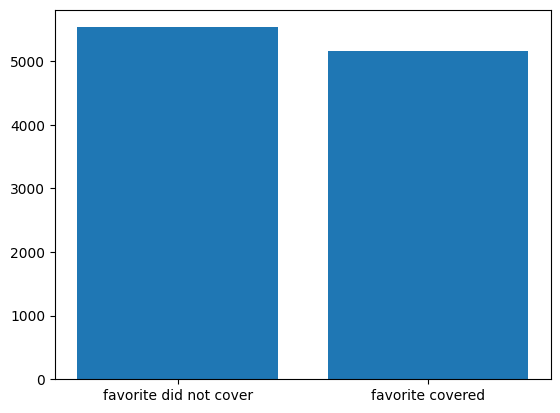

In [43]:
games['spread_favorite']
games.dropna(subset = ['spread_favorite','team_favorite_id'],inplace=True)
def covered(row):
    if row['team_favorite_id'] == row['home_abrev']:
        point_diff = row['score_home']-row['score_away']
    else:
        point_diff = row['score_away'] - row['score_home']
    if point_diff > np.abs(row['spread_favorite']):
        return True
    elif point_diff < np.abs(row['spread_favorite']):
        return False
    else:
        return np.nan
games['favorite_covered'] = games.apply(covered,axis=1)
plt.bar(x=["favorite did not cover", "favorite covered"] ,height = games['favorite_covered'].value_counts())

It looks like the spread favorite only covers the spread about 5195 / (5195 + 5570) * 100 = 48.25824431% of the time! which means the books are approximately 1.75% off when calculating their spread probabilities. 
While this may look like a small percentage, it's enough to work with and give me hope that we can in fact beat the books.


Let's look at the relationship between the predicted ELO probabilities and the actual win rates of games

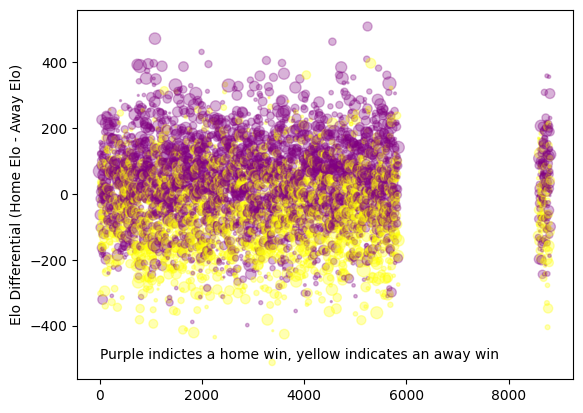

In [44]:
master_df['elo_diff'] = master_df['elo_home_pre'] - master_df['elo_away_pre']
plt.ylabel("Elo Differential (Home Elo - Away Elo)")
plt.annotate("Purple indictes a home win, yellow indicates an away win",xy=(0,-500))
plt.scatter(x=master_df.index,y=master_df['elo_diff'],c=master_df['winner_h_or_a'].map({'Home':'purple','Away':'yellow','Tie':'red'}),s=np.abs(master_df['point_diff'])*2, alpha = .3)

In [45]:
games['total'] = games['score_away'] + games['score_home']
highest_scoring = games.nlargest(n=250,columns='total')
highest_scoring.describe()

,schedule_date,schedule_season,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,point_diff,point_total,total
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,231.000000,230.000000,132.000000,250.000000,250.0000,250.0000
mean,2004-06-22 20:26:52.800000,2003.628000,41.720000,38.440000,-4.824000,45.224000,61.870130,5.460870,68.053030,4.728000,80.1600,80.1600
min,1979-09-02 00:00:00,1979.000000,21.000000,16.000000,-18.500000,32.000000,18.000000,0.000000,30.000000,-43.000000,74.0000,74.0000
25%,1995-03-29 12:00:00,1994.250000,37.000000,34.000000,-6.500000,42.000000,53.000000,0.000000,57.000000,-5.000000,76.0000,76.0000
50%,2006-04-26 12:00:00,2005.500000,41.000000,38.500000,-3.500000,45.000000,68.000000,6.000000,70.500000,3.000000,79.0000,79.0000
75%,2015-08-11 00:00:00,2014.750000,48.000000,44.000000,-3.000000,48.500000,72.000000,9.000000,79.000000,14.000000,83.0000,83.0000
max,2022-12-18 00:00:00,2022.000000,62.000000,59.000000,0.000000,63.500000,86.000000,18.000000,100.000000,35.000000,106.0000,106.0000
std,NaN,12.845139,7.717502,7.828893,3.276885,5.564321,14.311155,4.924384,15.072504,13.891939,6.0889,6.0889


Let's examine some of the highest ELO teams in the Superbowl era. By examining these teams we can try to look at similarities between them and see if we can identify common factors that indicate a team is on the rise. 

In [46]:
# first lets find the stronger opponent heading into a given matchup
sb_era_elo.loc[:,'stronger_team'] = sb_era_elo.loc[:,['elo1_pre','elo2_pre']].max(axis=1).copy()
#Now lets find the 250 strongest rated teams of the superbowl era and look at some summary statistics
strongest_250 = sb_era_elo.nlargest(250, columns='stronger_team')

In [47]:
def find_stronger_qb(row):
    if row['stronger_team'] == row['elo1_pre']:
        return row['qbelo1_pre']
    else:
        return row['qbelo2_pre']
strongest_250['stronger_team_qb_elo'] = strongest_250.apply(find_stronger_qb,axis=1)

<BarContainer object of 2 artists>

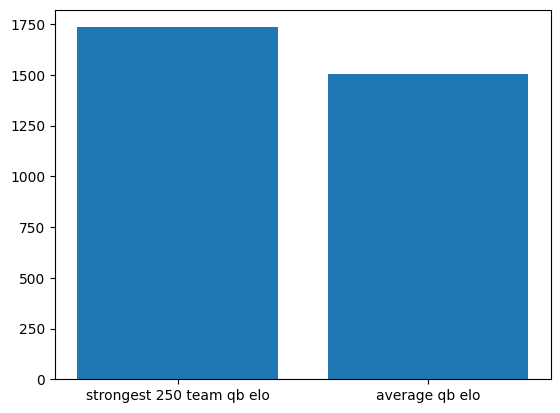

In [48]:
plt.bar(x=["strongest 250 team qb elo", "average qb elo"],height = [strongest_250['stronger_team_qb_elo'].mean(),(sb_era_elo['qbelo1_pre'].mean() + sb_era_elo['qbelo2_pre'].mean())/2])

These stats can give us a good idea of what an elite NFL team looks like. 

We can check out the correlation matrix for the superbowl era to give us a good idea of which variables are strongly related to each other

In [49]:
sb_era_elo.corr(numeric_only=True)

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,stronger_team
season,1.000000,0.021787,0.024954,0.028947,0.003498,-0.003498,0.027233,0.025448,0.020544,0.025191,0.261799,0.261631,0.017520,0.015722,0.004543,-0.004543,0.090914,0.082136,0.256858,0.254646,0.022847,0.021783,0.039718,0.036337,0.039180,NaN,NaN,-0.006780
neutral,0.021787,1.000000,0.110223,0.099897,-0.025850,0.025850,0.108497,0.097039,0.108706,0.098318,0.068679,0.063749,0.031569,0.019933,-0.018064,0.018064,0.036703,0.021846,0.070630,0.062510,0.106544,0.095677,0.011728,0.017685,0.091807,0.069313,0.068545,0.113712
elo1_pre,0.024954,0.110223,1.000000,0.056435,0.687653,-0.687653,0.978454,0.052674,0.989514,0.053588,0.511548,0.012756,0.118615,-0.002822,0.672571,-0.672571,0.188541,-0.055170,0.504647,-0.002543,0.967251,0.050276,0.224200,-0.187415,0.689064,0.266227,0.515381,0.636492
elo2_pre,0.028947,0.099897,0.056435,1.000000,-0.676385,0.676385,0.058536,0.977444,0.053843,0.989223,0.031778,0.482068,0.020693,0.087236,-0.633327,0.633327,-0.026110,0.180523,0.021793,0.476576,0.054476,0.965951,-0.164671,0.207001,0.679532,0.365420,0.568510,0.619140
elo_prob1,0.003498,-0.025850,0.687653,-0.676385,1.000000,-1.000000,0.670368,-0.662850,0.681672,-0.670261,0.349837,-0.337534,0.072734,-0.062962,0.956657,-0.956657,0.157949,-0.171758,0.352447,-0.345154,0.664995,-0.655966,0.281559,-0.287393,0.021143,-0.047994,-0.018732,-0.018259
elo_prob2,-0.003498,0.025850,-0.687653,0.676385,-1.000000,1.000000,-0.670368,0.662850,-0.681672,0.670261,-0.349837,0.337534,-0.072734,0.062962,-0.956657,0.956657,-0.157949,0.171758,-0.352447,0.345154,-0.664995,0.655966,-0.281559,0.287393,-0.021143,0.047994,0.018732,0.018259
elo1_post,0.027233,0.108497,0.978454,0.058536,0.670368,-0.670368,1.000000,0.011186,0.969075,0.054888,0.508013,0.005949,0.125811,-0.008372,0.660898,-0.660898,0.267353,-0.134912,0.521403,-0.028785,0.990587,0.007402,0.337221,-0.305294,0.677045,0.253994,0.498731,0.624572
elo2_post,0.025448,0.097039,0.052674,0.977444,-0.662850,0.662850,0.011186,1.000000,0.049258,0.967761,0.022140,0.479552,0.010004,0.091324,-0.625977,0.625977,-0.110900,0.260029,-0.008242,0.494423,0.005649,0.990203,-0.282703,0.328288,0.661868,0.365302,0.563552,0.603824
qbelo1_pre,0.020544,0.108706,0.989514,0.053843,0.681672,-0.681672,0.969075,0.049258,1.000000,0.051562,0.492790,0.010759,0.099719,0.000093,0.677885,-0.677885,0.186622,-0.057636,0.487404,-0.004952,0.977408,0.048367,0.225731,-0.188673,0.692374,0.254342,0.516545,0.628666
qbelo2_pre,0.025191,0.098318,0.053588,0.989223,-0.670261,0.670261,0.054888,0.967761,0.051562,1.000000,0.028403,0.462823,0.022622,0.067125,-0.637979,0.637979,-0.028247,0.175461,0.018237,0.458092,0.052273,0.976473,-0.165655,0.207099,0.681932,0.364718,0.582911,0.609794


#### Hypothesis
Games played in colder weather will tend to be lower scoring and therefore will not hit the over

<BarContainer object of 4 artists>

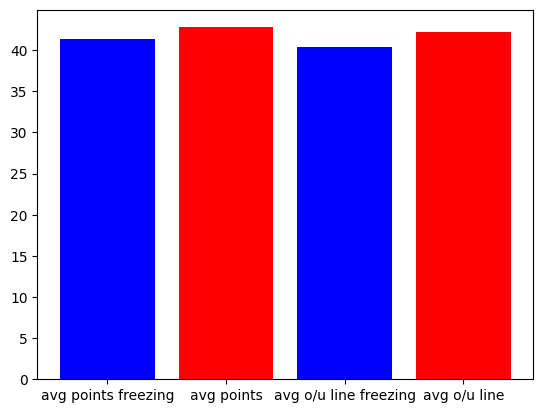

In [50]:
#Let's test out our theory
freezing = master_df[master_df['weather_temperature'] <= 32]
color = ['blue', 'red', 'blue', 'red']
plt.bar(x=['avg points freezing', 'avg points','avg o/u line freezing', 'avg o/u line'],height=[freezing['point_total'].mean(),master_df['point_total'].mean(),freezing
['over_under_line'].mean(),master_df['over_under_line'].mean()],color=color)

While it looks like games that are played in freezing temperatures are lower scoring on average, it looks like bookmakers are already accounting for that when calculating their totals for the game

In [129]:
y_features = ['over','covered','winner_h_or_a']
correlates = ['spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',]

<Axes: >

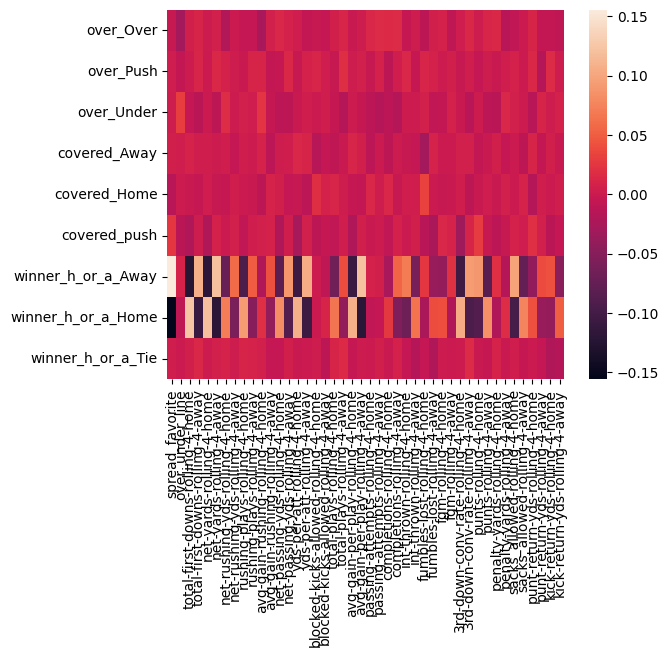

In [130]:
sns.heatmap(pd.get_dummies(master_df[correlates + y_features]).corr().filter(correlates).drop(correlates),xticklabels=True)

It looks like bookmakers are already adjusting for the weather. We need to start thinking outside the box and look for factors they haven't though about yet if we want to get an edge. 

Lets look at games that hit the over vs games that did not hit the over

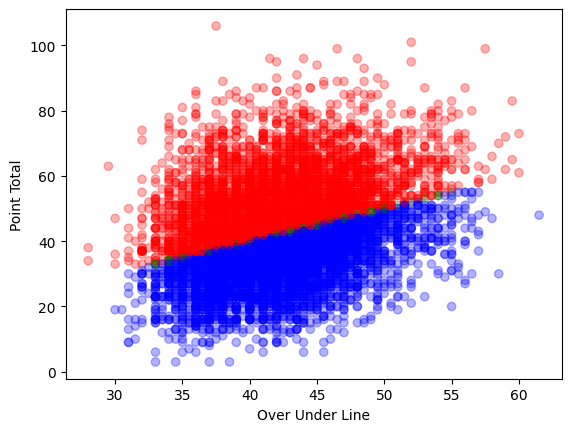

In [54]:
plt.ylabel("Point Total")
plt.xlabel("Over Under Line")
plt.scatter(x=master_df['over_under_line'],y=master_df['point_total'],c=master_df['over'].map({"Over":"red","Under":"blue","Push":"green"}), alpha = .3)

This scatter plot shows us games that hit the over in green, games that hit the under in red, and games that pushed in blue, with total points on the y-axis, and the over under line on the x. This is a good way to visualize the data as we can clearly see where the over-under line is on the plot. 

# Building a Model

Onto the good stuff:
My approach for my model is will be:
- Build a Machine Learning model using the master dataframe that predicts the probability of a team winning a given game (classification)
- Build a second model that predicts point totals of a game (regression)
- potential independent variables for the models will be, Team ELOs, QB Elos, sportsbook odds, season record, momentum score (fraction of x previous games won), weather, injuries, and any other useful statitistics I can find
- Dependent variables for the model will be the winner/win probability for the first model, and the predicted score for each team in the second model
- Test the model using cross validation
- Use the predictions and probabilities from the model, along with the new odds from the Odds API to identify potential positive EV bets
- Test to see if our identified "positive EV" bets are actually profitable. 
- Repeat until we make a model that is profitable

Assuming -110 odds on the over and the spread, that gives us an implied probability of:

    (110 / (100 + 110)) * 100 = 52.38%
    
This is our target number, if we want our model to be profitable, we need our accuracy to be above 52.38% on the over and the spread.

As for the moneyline model it's not quite as straight forward. Since there is not a fixed probability of -110, we need to use a combination of our accuracy, and our brier score to determine our model's predictions for the moneyline. 

We are going to have to build and test a lot of different models to find one that works. Let's start by building a pipeline to streamline the process. 

In [136]:
master_df_with_moneyline = pd.read_csv('Data/final_master_for_ml.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})
master_df = pd.read_csv('Data/final_master.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})

### Picking our model

In [137]:
#Define our training features
y_features = ['over','covered','winner_h_or_a']
x_features = [
 'spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 'home_favorite',]
x_features_ml = [
 'spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 'home_favorite',
 'Home Close Odds',
 'Home Open Odds',
 'Road Close Odds',
 'Road Open Odds',
 ]

Let's make some helper functions so we can test a bunch of different models to see what works best

In [153]:
def get_cv_scores(model,y_feat,x_features):
    '''
    Runs cross validation testing on models for given x and y features
    returns a dict containing the accuracy, f1, and log loss scores for the given model  
    '''
    features = x_features + [y_feat]
    if y_feat == 'winner_h_or_a':
        training_data = master_df_with_moneyline[features].dropna()
    else:
        training_data = master_df[features].dropna()
    x_dict = training_data[x_features].to_dict(orient="records")
    y_train = training_data[y_feat]
    pipe = Pipeline([("vec",DictVectorizer(sparse=False)),("scaler",MaxAbsScaler()),("clf",model)])
    scoring_metrics = {"accuracy":"accuracy","log loss":"neg_log_loss","f1":"f1_micro","precision":"precision_micro"}
    score = cross_validate(pipe,x_dict,y_train,scoring=scoring_metrics,error_score='raise')
    return score

In [157]:
def get_cv_scores_calibrated(model,y_feat,x_features):
    '''
    Runs cross validation testing on calibrated models  using the CalibratedClassifierCV function from sklearn for given x and y features
    returns a dict containing the accuracy, f1, and log loss scores for the given model   
    Calibration is best for reducing log loss scores, which is going to be most important when predicting the winner/moneyline for a game
    '''
    features = x_features + [y_feat]
    if y_feat == 'winner_h_or_a':
        training_data = master_df_with_moneyline[features].dropna()
    else:
        training_data = master_df[features].dropna()
    x_dict = training_data[x_features].to_dict(orient="records")
    y_train = training_data[y_feat]
    #pipe = Pipeline([("vec",DictVectorizer(sparse=False)),("scaler",MaxAbsScaler()),("clf",model)])
    pipe = Pipeline([("vec",DictVectorizer(sparse=False)),("scaler",MaxAbsScaler()),("clf",CalibratedClassifierCV(estimator=model,n_jobs=-1,cv=3,ensemble=True))])
    scoring_metrics = {"accuracy":"accuracy","log loss":"neg_log_loss","f1":"f1_micro","precision":"precision_micro"}
    score = cross_validate(pipe,x_dict,y_train,scoring=scoring_metrics,error_score='raise')
    return score

Let's compare some different models and their respective cross validated accuracy, f1, and log loss scores

In [158]:
def test_model(model):
    y_features = ['over','covered']
    scores = []
    for y_feature in y_features:
        if y_feature == 'winner_h_or_a':
            score = get_cv_scores_calibrated(model=model, y_feat=y_feature,x_features=x_features_ml)
        else:
            score = get_cv_scores_calibrated(model=model, y_feat=y_feature,x_features=x_features)
        scores.append((model,y_feature,score))
    return scores

In [159]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
scores = []
# RandomForestClassifier(), GradientBoostingClassifier(), ExtraTreesClassifier(),SGDClassifier(loss="log_loss",class_weight="balanced",average=True,),SVC(probability=True),
models = [LogisticRegression(max_iter=2500),KNeighborsClassifier(n_neighbors=100),RandomForestClassifier(), GradientBoostingClassifier(), ExtraTreesClassifier(),SGDClassifier(loss="log_loss",class_weight="balanced",average=True,max_iter=2500),SVC(probability=True,class_weight="balanced")]
for model in models:
    scores.append(test_model(model=model))


Now let's sort through the test results to find the models that return the best results for each metric. Let's take the mean of our 5 CV scores to make it easier to analyze the results

In [160]:
scores

[[(LogisticRegression(max_iter=2500),
   'over',
   {'fit_time': array([19.8407402 , 14.59769726, 17.56555152, 13.9788487 , 12.21582007]),
    'score_time': array([0.96315193, 2.72889662, 2.46304107, 1.16222358, 2.67679334]),
    'test_accuracy': array([0.50282486, 0.49887006, 0.50423968, 0.50367439, 0.5031091 ]),
    'test_log loss': array([-0.77231064, -0.77279782, -0.76999822, -0.76979002, -0.77366214]),
    'test_f1': array([0.50282486, 0.49887006, 0.50423968, 0.50367439, 0.5031091 ]),
    'test_precision': array([0.50282486, 0.49887006, 0.50423968, 0.50367439, 0.5031091 ])}),
  (LogisticRegression(max_iter=2500),
   'covered',
   {'fit_time': array([14.53941822, 13.05430222, 13.89049077, 13.26304984, 14.71462822]),
    'score_time': array([2.63149381, 2.02139688, 2.69398165, 2.38555145, 2.34877253]),
    'test_accuracy': array([0.50451977, 0.50112994, 0.5031091 , 0.50480497, 0.50367439]),
    'test_log loss': array([-0.79998901, -0.80043404, -0.79880655, -0.80023587, -0.79971044])

In [ ]:
all_mean_scores = []
for score in scores:
    for feature_score in score:
        all_mean_scores.append((feature_score[0],feature_score[1],f"accuracy: {feature_score[2]['test_accuracy'].mean()} | log loss: {feature_score[2]['test_log loss'].mean()} |f1: {feature_score[2]['test_f1'].mean()}|precision: {feature_score[2]['test_precision'].mean()}"))

Let's check out our results. Keep in mind our most important metric for the spread and the total are accuracy and the most important metrics for moneyline is log loss and accuracy. 

In [ ]:
all_mean_scores

Best performing models for predicting the over (>60% accuracy and precision):
1) SGDClassifier(average=True, class_weight='balanced', loss='log_loss',max_iter=2500)
2) LogisticRegression(max_iter=2500)
3) GradientBoostingClassifier()
4) SVC(class_weight='balanced', probability=True)

Best performing models for predicting the spread (>60% accuracy and precision): 
1) SVC(class_weight='balanced', probability=True)
2) KNeighborsClassifier(n_neighbors=100)

Best performing models for predicting the winner/moneyline (>72% accuracy, >-.55 log loss):
1) SGDClassifier(average=True, class_weight='balanced', loss='log_loss',max_iter=2500)
2) LogisticRegression(max_iter=2500)
3) GradientBoostingClassifier()


Now let's test our models for consistent profitability
we will do this by with the following procedure:
1) Run the function below 10 times for each model to ensure *consistent* performance
2) Use hyper parameter tuning to get the best performance out of each model
3) Once hyperparameters for each model have been selected, re-evaluate each model by repeating step 1 to ensure *consistent* performance
4) repeat if model re-evaluation is not satisfactory

Admittedly, a lot of these algorithms are somewhat of a black box to me, and although I have read some of scikit-learn's documentation for them, further research on how they work will definitely help improve the future of this project.

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def place_test_bet(predicted,actual,odds,bet):
    # If our predicted value == actual value return the winnings, else return -bet size
        if predicted == actual:
            return odds * bet + bet
        elif actual == "Push":
            return bet
        else:
            return -bet

def size_kelly_bet(bankroll, win_prob,odds):
    # size bet according to the kelly criterion
    return bankroll * (win_prob - (1-win_prob)/odds)

def calc_ev(bet_size,win_prob,odds):
    # calculate the expected value of a bet
    ev = bet_size * odds * win_prob - bet_size*(1-win_prob)
    return ev

def test_profitability(x_features,y_feature,probability_threshold,bankroll,test_model,max_bet):
    '''
    Tests the profitability of a bet by retroactively betting on past games using cross validation
    Params: 
        x_features: X columns to train the model on
        y_feature: y feature that is being predicted
        probability threshold: The probability threshold has a different meaning depending on the feature being predicted. If
        we are predicting the moneyline, the probability threshold is a value such that we want our prediction to be that value above 
        the implied probabiity from the odds for us to feel comofortable placing a bet. 
        If we are predicting the over or the spread, the probability threshold is the value we want our predicted probability of
        a team hitting the over or covering the spread to be above. 
        Bankroll: Our starting bankroll
        test_model: The model we are testing
        k: a parameter for the model, useful for trying to optimize the value of a specific parameter. 
    Returns:
        A dictionary containing our final bankroll, our models true accuracy, our models adjusted accuracy after using the probability threshold,
        the number of successful bets, the number of unsuccessful bets, the number of bets we did not place (model evaluated as not +ev)
        A list that tracks our bankroll after each bet
        A list that tracks our ev after each bet
        A list that tracks the size of each bet
        A list that tracks the results of each bet
    '''
    features = x_features + [y_feature]
    if y_feature == "over" or y_feature == "covered":
        training_data = master_df[features].dropna()
    # I could only get historical moneylines from 2007-present so we have to use a different dataset (about 300 rows) for predicting outright winners
    elif y_feature == "winner_h_or_a":
        training_data = master_df_with_moneyline[features].dropna()
    # split the training data for cross validation
    x_training_data,x_test_data,y_train,y_test = train_test_split(training_data[x_features],training_data[y_feature],test_size=.2)
    x_dict_train = x_training_data.to_dict(orient="records")
    x_dict_test = x_test_data.to_dict(orient="records")
    # one hot encode categorical variables for training data
    vec = DictVectorizer(sparse=False)
    vec.fit(x_dict_train)
    x_train = vec.transform(x_dict_train)
    # scale data
    scaler = MaxAbsScaler()
    scaler.fit(x_train)
    x_train_sc = scaler.transform(x_train)
    # Use the calibrated classifier to calibrate the probabilities of our model and get the most accurate predictions. 
    model = CalibratedClassifierCV(estimator=test_model,method='isotonic')
    # fit the model to the training data
    model.fit(x_train_sc,y_train)
    # one hot encode categorical variables for testing data
    vec = DictVectorizer(sparse=False)
    vec.fit(x_dict_test)
    x_test = vec.transform(x_dict_test)
    # scale testing data
    scaler = MaxAbsScaler()
    scaler.fit(x_test)
    x_test_sc = scaler.transform(x_test)
    # predict outcomes for the testing data
    y_pred_prob = model.predict_proba(x_test_sc)
    y_pred = model.predict(x_test_sc)
    #compare predicted values to actual values
    y_pred_lst = list(y_pred)
    y_test_lst = list(y_test)
    predictions_vs_results = list(zip(y_pred_prob,y_pred,y_test_lst))
    # display(predictions_vs_results)
    #start with a bankroll of 1000
    bets = []
    profits_over_time = [0]
    bet_evs = []
    bet_results = []
    bankroll = 1000
    accuracy = accuracy_score(y_pred=y_pred_lst, y_true=y_test_lst)
    hits = 0
    misses = 0
    no_bet = 0
    #simulate betting on past games based off of our test predictions
    for i in range(len(predictions_vs_results)):
        pred = predictions_vs_results[i][1]
        actual = predictions_vs_results[i][2]
        if y_feature == 'winner_h_or_a':
            # get the closing odds
            if pred == "Home":
                predicted_prob = predictions_vs_results[i][0][0]
                american_odds = training_data['Home Close Odds'].loc[i]
            elif pred == "Away":
                predicted_prob = predictions_vs_results[i][0][1]
                american_odds = training_data['Road Close Odds'].loc[i]
            # convert the american odds to the implied probability
            if american_odds > 0:
                implied_prob = (100 / (american_odds + 100)) * 100
                decimal_odds = (american_odds / 100) + 1 
            else:
                implied_prob = (np.abs(american_odds) / (np.abs(american_odds) + 100)) * 100
                decimal_odds = (100 / np.abs(american_odds)) + 1
            
            bet = size_kelly_bet(bankroll=bankroll,win_prob=predicted_prob,odds=implied_prob)
            if bet > max_bet * bankroll:
                bet = max_bet * bankroll
            ev = calc_ev(bet_size=bet,win_prob=predicted_prob - probability_threshold,odds=decimal_odds)
            bet_evs.append(ev)
        else:
            if y_feature == 'over':
                if pred == 'Over':
                    predicted_prob = predictions_vs_results[i][0][0]
                elif pred == 'Under':
                    predicted_prob = predictions_vs_results[i][0][2]
                else:
                    continue
                if predicted_prob > probability_threshold:
                    bet = size_kelly_bet(bankroll=bankroll,win_prob=accuracy,odds=.91)
                    if bet > max_bet * bankroll:
                        bet = max_bet * bankroll
                    ev = calc_ev(bet_size=bet,win_prob=accuracy,odds=.91)
                    bet_evs.append(ev)
                else:
                    bet = 0
                    ev = 0
            elif y_feature == 'covered':
                if pred == "Home":
                    predicted_prob = predictions_vs_results[i][0][1]
                elif pred == 'Away':
                    predicted_prob = predictions_vs_results[i][0][0]
                else:
                    continue
                if predicted_prob > probability_threshold:
                    bet = size_kelly_bet(bankroll=bankroll,win_prob=predicted_prob,odds=.91)
                    if bet > max_bet * bankroll:
                        bet = max_bet * bankroll
                    ev = calc_ev(bet_size=bet,win_prob=accuracy,odds=.91)
                    bet_evs.append(ev)
                else:
                    bet = 0
                    ev = 0
            else:
                return f"You entered y_feature = {y_feature}, please select either 'over', 'covered', or 'winner_h_or_a'"
            
        if ev > 0:
            bankroll = bankroll
            returns = place_test_bet(predicted=pred,actual=actual,odds=.91,bet=bet)
            bets.append(bet)
        else:
            returns = 0
            bets.append(0)
        if returns > bet:
            hits += 1
        elif returns == 0:
            no_bet+=1
        else:
            misses += 1
        bet_results.append(returns)
        bankroll += returns
        profits_over_time.append(bankroll-1000)
            
        if hits + misses != 0:
            adjusted_accuracy = hits / (hits + misses)
        else:
            adjusted_accuracy = np.nan
    return ({"profit": bankroll-1000, "pure accuracy": accuracy , "adjusted accuracy": adjusted_accuracy,"hits":hits,"misses":misses,"num skipped bets":no_bet},profits_over_time,bet_evs,bets,bet_results)

Let's test our model's profitability, to get a general idea of our performance we will run the test 5 times and observe variations in our results.

In [194]:
over_results_SGD = []
over_results_LR = []
over_results_GB = []
over_results_SVC = []
spread_results_SVC = []
spread_results_KN = []
moneyline_results_SGD = []
moneyline_results_LR = []
moneyline_results_GB = []

for i in range(1,8):
    thresh = i/100
    over_results_SGD.append(test_profitability(x_features=x_features,y_feature='over',probability_threshold=.5+thresh,bankroll=1000,test_model=SGDClassifier(average=True, class_weight='balanced', loss='log_loss',max_iter=2500),max_bet=.05))
    #over_results_LR.append(test_profitability(x_features=x_features,y_feature='over',probability_threshold=.53,bankroll=1000,test_model=LogisticRegression(max_iter=2500),max_bet=.05))
    #over_results_GB.append(test_profitability(x_features=x_features,y_feature='over',probability_threshold=.53,bankroll=1000,test_model=GradientBoostingClassifier(),max_bet=.05))
    over_results_SVC.append(test_profitability(x_features=x_features,y_feature='over',probability_threshold=.5+thresh,bankroll=1000,test_model=SVC(probability=True,class_weight='balanced'),max_bet=.05))
    spread_results_SVC.append(test_profitability(x_features=x_features,y_feature='covered',probability_threshold=.53,bankroll=1000,test_model=SVC(probability=True,class_weight='balanced',C=.8),max_bet=.05))
    #spread_results_KN.append(test_profitability(x_features=x_features,y_feature='covered',probability_threshold=.55,bankroll=1000,test_model=SVC(probability=True,class_weight='balanced',C=.8),max_bet=.05))
    moneyline_results_SGD.append(test_profitability(x_features=x_features_ml,y_feature='winner_h_or_a',probability_threshold=thresh,bankroll=1000,test_model=KNeighborsClassifier(n_neighbors=100),max_bet=.05))
    #moneyline_results_LR.append(test_profitability(x_features=x_features_ml,y_feature='winner_h_or_a',probability_threshold=.0,bankroll=1000,test_model=LogisticRegression(max_iter=3000,class_weight='balanced',C=1),max_bet=.05))
    #moneyline_results_GB.append(test_profitability(x_features=x_features_ml,y_feature='winner_h_or_a',probability_threshold=.0,bankroll=1000,test_model=GradientBoostingClassifier(),max_bet=.05))
    

Feature selection

In [69]:
from sklearn.feature_selection import RFE
get_cv_scores(RFE(estimator=SGDClassifier(average=True, class_weight='balanced', loss='log_loss',max_iter=2500),n_features_to_select=250),y_feat='over',x_features=x_features)

{'fit_time': array([4.72914624, 4.97285771, 4.04625416, 3.75396514, 3.72237945]),
 'score_time': array([1.18304825, 0.93368649, 0.93341565, 0.89850616, 0.70142841]),
 'test_accuracy': array([0.37605872, 0.45454545, 0.3960452 , 0.45819209, 0.57457627]),
 'test_log loss': array([-1.30171614, -1.25767441, -1.32431187, -1.30605354, -1.52035318]),
 'test_f1': array([0.37605872, 0.45454545, 0.3960452 , 0.45819209, 0.57457627]),
 'test_precision': array([0.37605872, 0.45454545, 0.3960452 , 0.45819209, 0.57457627])}

After the first round of profitability testing, it appears that The stochastic gradient descent model is the most consistent in predicting the over and the spread. the support vector classifier (SVC) is my the best predictor of the spread. Next step is to fine tune the parameters of the models. 

In [195]:
def get_results(results):
    scores = []
    profits = []
    evs = []
    bet_sizes = []
    bet_results = []
    for result in results:
        scores.append(result[0])
        profits.append(result[1])
        evs.append(result[2])
        bet_sizes.append(result[3])
        bet_results.append(result[4])
    return scores,profits,evs,bet_sizes,bet_results


SGD_over_scores,SGD_over_profits,SGD_over_evs,SGD_over_bet_sizes,SGD_over_bet_results= get_results(over_results_SGD)
SVC_over_scores,SVC_over_profits,SVC_over_evs,SVC_over_bet_sizes,SVC_over_bet_results = get_results(over_results_SVC)
SVC_spread_scores,SVC_spread_profits,SVC_spread_evs,SVC_spread_bet_sizes,SVC_spread_bet_results= get_results(spread_results_SVC)
SGD_moneyline_scores,SGD_moneyline_profits,SGD_moneyline_evs,SGD_moneyline_bet_sizes,SGD_moneyline_bet_results= get_results(moneyline_results_SGD)

Let's check our results!

In [196]:
SVC_spread_scores

[{'profit': 0,
  'pure accuracy': 0.49887005649717514,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.5096045197740113,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.5067796610169492,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.5050847457627119,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.496045197740113,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.5,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770},
 {'profit': 0,
  'pure accuracy': 0.5062146892655367,
  'adjusted accuracy': nan,
  'hits': 0,
  'misses': 0,
  'num skipped bets': 1770}]

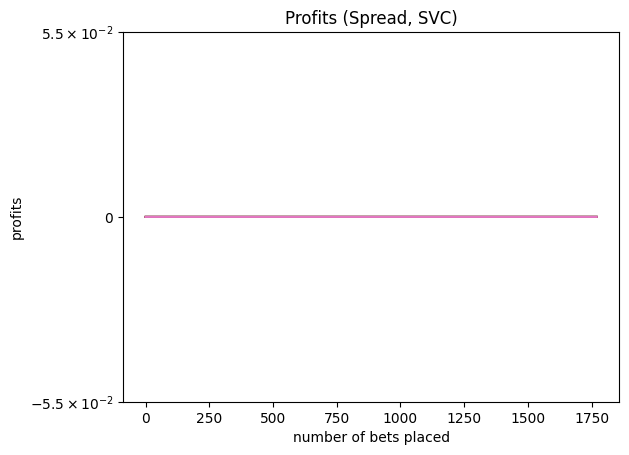

In [197]:
plt.yscale("symlog")
plt.ylabel("profits")
plt.xlabel("number of bets placed")
plt.title("Profits (Spread, SVC)")
for result_profit in SVC_spread_profits:
    plt.plot(result_profit)

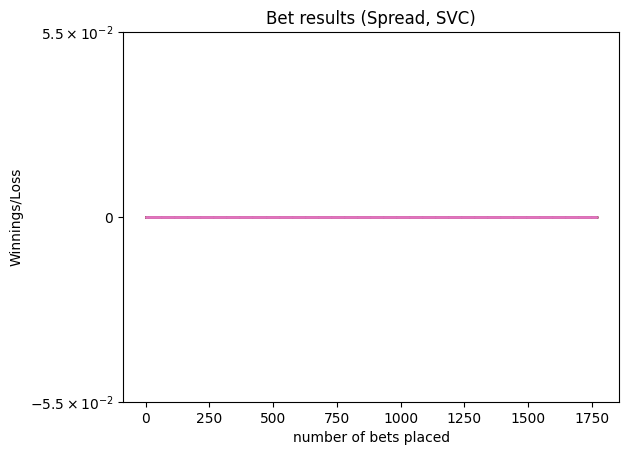

In [198]:
plt.yscale("symlog")
plt.ylabel("Winnings/Loss")
plt.xlabel("number of bets placed")
plt.title("Bet results (Spread, SVC)")
for result in SVC_spread_bet_results:
    plt.scatter(y=result,x=range(len(result)),alpha=.5,s=.5)

[{'profit': -999.9998567459872,
  'pure accuracy': 0.48757062146892655,
  'adjusted accuracy': 0.5062344139650873,
  'hits': 203,
  'misses': 198,
  'num skipped bets': 1369},
 {'profit': -998.8367006902464,
  'pure accuracy': 0.4994350282485876,
  'adjusted accuracy': 0.4549763033175355,
  'hits': 96,
  'misses': 115,
  'num skipped bets': 1559},
 {'profit': -941.8772951050116,
  'pure accuracy': 0.496045197740113,
  'adjusted accuracy': 0.48863636363636365,
  'hits': 43,
  'misses': 45,
  'num skipped bets': 1682},
 {'profit': -536.536325184507,
  'pure accuracy': 0.5124293785310734,
  'adjusted accuracy': 0.47540983606557374,
  'hits': 29,
  'misses': 32,
  'num skipped bets': 1709},
 {'profit': -622.5283661018709,
  'pure accuracy': 0.5056497175141242,
  'adjusted accuracy': 0.3939393939393939,
  'hits': 13,
  'misses': 20,
  'num skipped bets': 1737},
 {'profit': -105.19783698467188,
  'pure accuracy': 0.5062146892655367,
  'adjusted accuracy': 0.6111111111111112,
  'hits': 11,
  

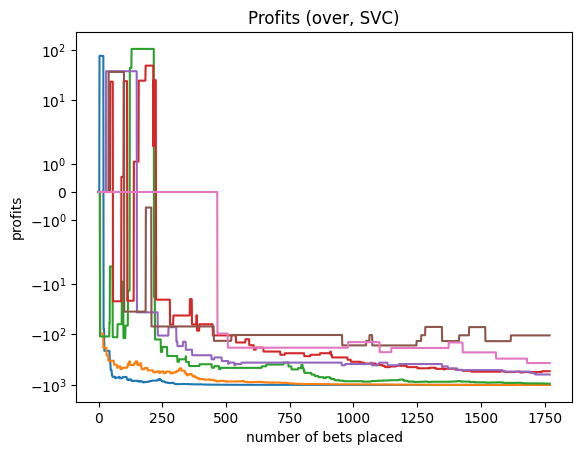

In [199]:
plt.yscale("symlog")
plt.ylabel("profits")
plt.xlabel("number of bets placed")
plt.title("Profits (over, SVC)")
display(SVC_over_scores)
for result in SVC_over_profits:
    plt.plot(result)

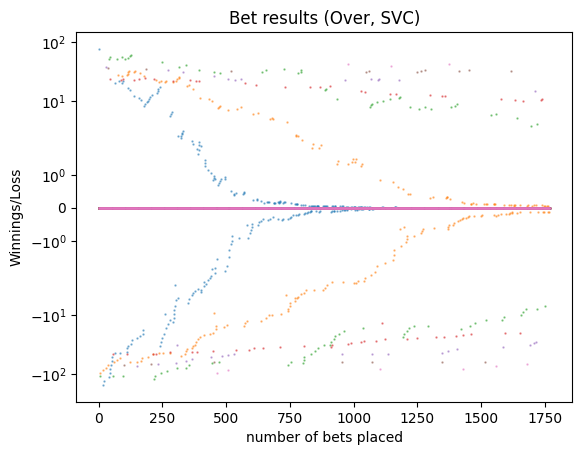

In [200]:
plt.yscale("symlog")
plt.ylabel("Winnings/Loss")
plt.xlabel("number of bets placed")
plt.title("Bet results (Over, SVC)")
for result in SVC_over_bet_results:
    plt.scatter(y=result,x=range(len(result)),alpha=.5,s=.5)

[{'profit': -999.9999999999991,
  'pure accuracy': 0.5011299435028248,
  'adjusted accuracy': 0.4814264487369985,
  'hits': 648,
  'misses': 698,
  'num skipped bets': 424},
 {'profit': -999.9993408235913,
  'pure accuracy': 0.4864406779661017,
  'adjusted accuracy': 0.5285359801488834,
  'hits': 213,
  'misses': 190,
  'num skipped bets': 1367},
 {'profit': -999.9848903535026,
  'pure accuracy': 0.48135593220338985,
  'adjusted accuracy': 0.5,
  'hits': 116,
  'misses': 116,
  'num skipped bets': 1538},
 {'profit': -999.5070115043786,
  'pure accuracy': 0.4909604519774011,
  'adjusted accuracy': 0.49760765550239233,
  'hits': 104,
  'misses': 105,
  'num skipped bets': 1561},
 {'profit': -900.3587480968289,
  'pure accuracy': 0.5033898305084745,
  'adjusted accuracy': 0.4606741573033708,
  'hits': 41,
  'misses': 48,
  'num skipped bets': 1681},
 {'profit': -723.9907660356348,
  'pure accuracy': 0.5022598870056497,
  'adjusted accuracy': 0.5394736842105263,
  'hits': 41,
  'misses': 3

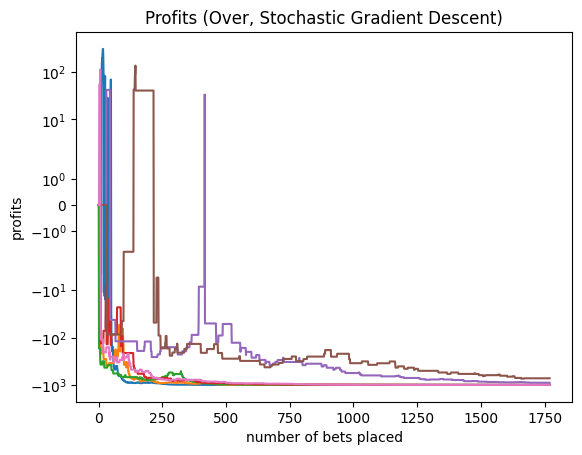

In [201]:
plt.yscale("symlog")
plt.ylabel("profits")
plt.xlabel("number of bets placed")
plt.title("Profits (Over, Stochastic Gradient Descent)")
display(SGD_over_scores)
for result in SGD_over_profits:
    plt.plot(result)

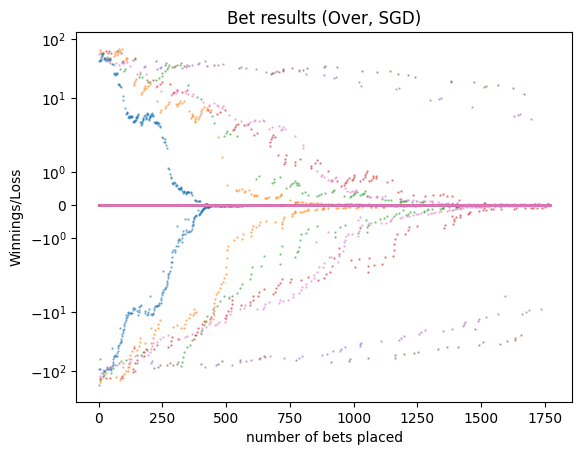

In [202]:
plt.yscale("symlog")
plt.ylabel("Winnings/Loss")
plt.xlabel("number of bets placed")
plt.title("Bet results (Over, SGD)")
for result in SGD_over_bet_results:
    plt.scatter(y=result,x=range(len(result)),alpha=.5,s=.5)

[{'profit': 144999720.5950417,
  'pure accuracy': 0.6930860033726813,
  'adjusted accuracy': 0.6605839416058394,
  'hits': 181,
  'misses': 93,
  'num skipped bets': 319},
 {'profit': 45624299.565451495,
  'pure accuracy': 0.6593591905564924,
  'adjusted accuracy': 0.6439393939393939,
  'hits': 170,
  'misses': 94,
  'num skipped bets': 329},
 {'profit': 2346608.746688856,
  'pure accuracy': 0.6340640809443507,
  'adjusted accuracy': 0.5899581589958159,
  'hits': 141,
  'misses': 98,
  'num skipped bets': 354},
 {'profit': 15043064.20309493,
  'pure accuracy': 0.6644182124789207,
  'adjusted accuracy': 0.6305220883534136,
  'hits': 157,
  'misses': 92,
  'num skipped bets': 344},
 {'profit': 1487736.1578986826,
  'pure accuracy': 0.6593591905564924,
  'adjusted accuracy': 0.6108374384236454,
  'hits': 124,
  'misses': 79,
  'num skipped bets': 390},
 {'profit': 878341.2541254882,
  'pure accuracy': 0.6829679595278246,
  'adjusted accuracy': 0.5931372549019608,
  'hits': 121,
  'misses'

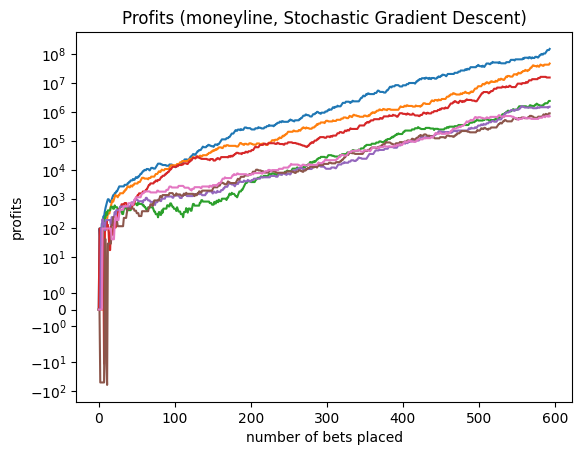

In [203]:
plt.yscale("symlog")
plt.ylabel("profits")
plt.xlabel("number of bets placed")
plt.title("Profits (moneyline, Stochastic Gradient Descent)")
display(SGD_moneyline_scores)
for result in SGD_moneyline_profits:
    plt.plot(result)

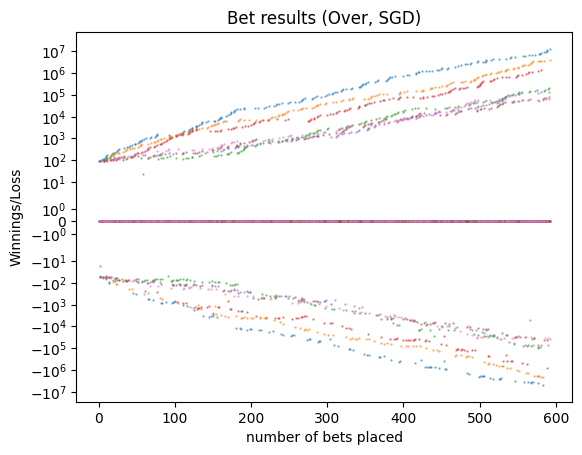

In [204]:
plt.yscale("symlog")
plt.ylabel("Winnings/Loss")
plt.xlabel("number of bets placed")
plt.title("Bet results (Over, SGD)")
for result in SGD_moneyline_bet_results:
    plt.scatter(y=result,x=range(len(result)),alpha=.5,s=.5)

### Analyzing our results
The results from these models are not bad. Our spread model seems to be by far the strongest. However our over model(s) are a little inconsistent, and our 

1) **Adjust maximum bet size:** Currently I have the maximum bet size set to 5% of the current bankroll. Perhaps setting it to a lower value will help mitigate the risk of a big loss, as it seems big losses early on in the betting simulation (< 100 games) is often what gets us stuck in a hole we can't get out of. 
2) **Adjusting model hyper parameters:** Our model may not be perfectly calibrated. As stated before to be profitable our model needs to be accurate >53% of the time. In our losing model our pure accuracy was around 51%. This could potentially be fixed by tuning the model's hyper parameters. Currently I am using a support vector machine classifier (SVC) paired with sci kit learn's CalibratedClassifierCV to try to get a more accurate probability. Perhaps with some hyper parameter tuning of both our model and the CalibratedClassifierCV we can make our accuracy more consistent. My first step with this will be to test out lower values of C, which according to the documentation from scikit-learn
3) **Adjust probability threshold:** In most scenarios our adjusted accuracy is higher than our pure accuracy (which means it was successfully mitigating risk). However in our losing model our adjusted accuracy score was significantly lower than our pure accuracy (~45% adjusted compared to 51% pure). This likely indicates a problem with our probability calibration, as this indicates some of our models more certain predictions (probability > 55%) were less accurate than the models less certain predictions (probability >50%) and this should not be the case. This means our over model's probability predictions are not properly calibrated and should be likely be adjusted.  
4) **Use a safer model with higher precision:** In the context of gambling, using a model with high precision is very important, as false positive predictions are what will ultimately lead to a failing model and losing all of our money. And while high recall is also important, as we don't want to miss out on winning bets, when real money is at stake the tradeoff of smaller returns for increased peace of mind may be worth it. Finding a way to adjust the model to increase precision may be something worth looking into further. 
5) **Feature selection:** There could be some problems with the features I have decided to train my model on. The biggest one that comes to mind is that for my rolling averages of box score stats from previous games, I am missing a lot of key stats on defense (which is particularly important when calculating the over). It could be a good idea to go back and calculate things like average yards allowed, average points allowed, 3rd down conversion rate allowed, etc... The bigest potential caviat with this is the overfitting problem, which we may already be experiencing. Although my models are mostly accurate, perhaps trimming down the features rather than adding new ones could be a good idea as I am already training on over 300 features. A potential tool that could be helpful for this is scikit learn's SequentialFeatureSelector (although with 300 features it may take a long time to run). Addiitonally, there are a lot of things that impact an outcome of a game that don't have to do with stats that I would like to find a way to account for (Star player injuries/suspensions and coaching changes are the two biggest that come to mind). 
6) **Use a different model:** Although in my preliminary testing rounds logistic regression and SVC were my two highest scoring models for predicting the over, they haven't been able to consistently be profitable, returning losing models about 10-20% of the time. It could be worth it to test out other models and see if they are more consistently profitable. 

However even if I tackle all of these problems there is still no guarantee that the model will always be profitable. 

In [ ]:
def find_best_odds(odds_df):
    '''
    function that performs a line search on the odds dataframe to find and return the best odds for each game
    returns: list of dataframes of the best odds for each market of each game
    '''
    ids = pd.unique(odds_df['id'])
    markets = pd.unique(odds_df['bookmakers.markets.key'])
    games = odds_df.groupby(by=['id','bookmakers.markets.key'])
    all_games_lst = []
    best_bets = []
    for id in ids:
        for market in markets:
            if market in odds_df[odds_df['id'] == id]['bookmakers.markets.key'].tolist():
                game_market_odds = odds_df.iloc[games.groups[(id,market)]]
                all_games_lst.append(game_market_odds)
    for game in all_games_lst:
        h2h_odds = game[game['bookmakers.markets.key'] == 'h2h']
        h2h_lay_odds = game[game['bookmakers.markets.key'] == 'h2h_lay']
        spread_odds = game[game['bookmakers.markets.key'] == 'spread']
        over_under_odds = game[game['bookmakers.markets.key'] == 'totals']

        home_odds_h2h = h2h_odds[h2h_odds['name'] == h2h_odds['home_team']]
        away_odds_h2h = h2h_odds[h2h_odds['name'] == h2h_odds['away_team']]
        best_home_odds_h2h = home_odds_h2h.loc[home_odds_h2h['price'] == home_odds_h2h['price'].max()]
        best_bets.append(best_home_odds_h2h)
        best_away_odds = away_odds_h2h.loc[away_odds_h2h['price'] == away_odds_h2h['price'].max()]
        best_bets.append(best_away_odds)


        home_odds_h2h_lay = h2h_lay_odds[h2h_lay_odds['name'] == h2h_lay_odds['home_team']]
        away_odds_h2h_lay = h2h_lay_odds[h2h_lay_odds['name'] == h2h_lay_odds['away_team']]
        best_home_odds_h2h_lay = home_odds_h2h_lay.loc[home_odds_h2h_lay['price'] == home_odds_h2h_lay['price'].max()]
        best_bets.append(best_home_odds_h2h_lay)
        best_away_odds_h2h_lay = away_odds_h2h_lay.loc[away_odds_h2h_lay['price'] == away_odds_h2h_lay['price'].max()]
        best_bets.append(best_away_odds_h2h_lay)

        home_odds_spread = spread_odds[spread_odds['name'] == spread_odds['home_team']]
        away_odds_spread = spread_odds[spread_odds['name'] == spread_odds['away_team']]
        spreads = pd.unique(spread_odds['point'])
        for spread in spreads:
            home_line_odds_spread = home_odds_spread.loc[home_odds_spread['price'] == spread]
            best_home_odds_for_spread = home_line_odds_spread.loc[home_line_odds_spread['price'] == home_line_odds_spread['price'].max()]
            best_bets.append(best_home_odds_for_spread)

            away_line_odds_spread = away_odds_spread.loc[away_odds_spread['price'] == spread]
            best_away_odds_for_spread = away_line_odds_spread.loc[away_line_odds_spread['price'] == away_line_odds_spread['price'].max()]
            best_bets.append(best_away_odds_for_spread)
     
        
        home_odds_over_under = over_under_odds[over_under_odds['name'] == over_under_odds['home_team']]
        away_odds_over_under = over_under_odds[over_under_odds['name'] == over_under_odds['away_team']]
        lines = pd.unique(over_under_odds['point'])
        for line in lines:
            home_line_odds = home_odds_over_under.loc[home_odds_over_under['price'] == line]
            best_home_line_price = home_line_odds.loc[home_odds_over_under['price'] == home_odds_over_under['price'].max()]
            best_bets.append(best_home_line_price)

            away_line_odds = away_odds_over_under.loc[away_odds_over_under['price'] == line]
            best_away_line_price = away_line_odds.loc[away_odds_over_under['price'] == away_odds_over_under['price'].max()]
            best_bets.append(best_away_line_price)

    return best_bets
    
best = find_best_odds(odds_df)

#remove empty dfs from best
best_odds = []
for df in best:
    if not df.empty:
        best_odds.append(df)

# Next Steps:

Although I have (mostly) profitable models, there are still some things that need to be done before II can start using this model to predict the outcome of games that haven't yet happened. 

1) **Keeping stats up to date** To take care of step 2 I will continue to use the webscraper I wrote earlier that scrapes footballdb.com. I will likely have to manually run it Tuesday morning (once all the games for the week are finished). It could be worth looking into a way to automate this process, although I'm not really sure where to start with that. 
2) **Test the model on unseen data:** Although the cross validation scores are encouraging, I won't truly know if my model is generalizable until I test it on games that have not yet happened. If I find it is not profitable, I will have to go back and readjust. 
3) **Profit:** There are two ways I can profit off of my model, the most obvious way is to use it myself. The second way would be to sell access to the model to the public, likely through a monthly subscription service. To do this would require a lot more effort, as not only would I have to build new models for other sports as football is not played year round, but I would also have to design some sort of interface that allows people to access the model. The two ways I could do this would either be through a website that gives people direct access to the model, or through a website that allows people to sign up for an email list where I can send out the model's picks every day. 

# Conclusion:
This project was a blast and I am really proud of myself for coming as far as I did. With that being said, I still have a lot of work to do, and while I may be turning this in for a final grade, I don't think this will be the final version of this project. This is the first time I have ever been so engrossed by a project for school that I want to continue working on it after the class is over. This class has inspired me and made me feel like I am capable of a lot more than I ever thought I could be 6 months ago, so far that I want to say thank you. If you wish to stay updated on the project let me know, as I would love to continue to get feedback as the project progresses. I plan on going through the four steps I listed above, and then depending on how long that takes, repeating the entire process again with another sport (either baseball or hockey next). While I originally chose football because it was the sport I had the mosst knowledge and interest with, it has a pretty large drawback in the context of data in that it has a short season with not that many games (there are about 10x as many games per season in baseball).